# **Loan Default Risk Analysis**

**Course: ADA-2504 | Dataset: Credit Risk Dataset – Kaggle**

**Team Members: Dana Satvaldina, Zarina Nurzhanova,Turar Kairetdinov**



**Project Goal**
The goal of this project is to predict the likelihood of loan default based on client and loan characteristics, and to compare the performance of three different machine learning models.
By analyzing risk factors, the team aims to help financial institutions identify potential defaulters more accurately.

# **1. Exploratory Data Analysis**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

In [ ]:
df = pd.read_csv("credit_risk_dataset.csv")

### General Data Overview

In [ ]:
print(f"Dataset size: {df.shape[0]} rows × {df.shape[1]} columns\n")

print("First 5 rows:")
print(tabulate(df.head(), headers="keys", tablefmt="pretty", showindex=False))


Dataset size: 32581 rows × 12 columns

First 5 rows:
+------------+---------------+-----------------------+-------------------+-------------+------------+-----------+---------------+-------------+---------------------+---------------------------+----------------------------+
| person_age | person_income | person_home_ownership | person_emp_length | loan_intent | loan_grade | loan_amnt | loan_int_rate | loan_status | loan_percent_income | cb_person_default_on_file | cb_person_cred_hist_length |
+------------+---------------+-----------------------+-------------------+-------------+------------+-----------+---------------+-------------+---------------------+---------------------------+----------------------------+
|     22     |     59000     |         RENT          |       123.0       |  PERSONAL   |     D      |   35000   |     16.02     |      1      |        0.59         |             Y             |             3              |
|     21     |     9600      |          OWN          | 

### Data Information

In [ ]:
info_df = pd.DataFrame({
    "Data type": df.dtypes,
    "Non-null count": df.count(),
    "Missing values": df.isnull().sum()
}).reset_index().rename(columns={'index': 'Feature'})
info_df.insert(0, '#', range(1, len(info_df) + 1))
print("Dataset structure and missing values")
print(tabulate(info_df, headers="keys", tablefmt="pretty", showindex=False))

num_cols = ['person_age', 'person_income', 'person_emp_length',
            'loan_amnt', 'loan_int_rate', 'loan_percent_income',
            'cb_person_cred_hist_length']

desc = df[num_cols].describe().T
desc = desc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].round(2)
desc = desc.reset_index().rename(columns={'index': 'Feature'})
desc.insert(0, '#', range(1, len(desc) + 1))
print("\nDescriptive statistics for numerical features")
print(tabulate(desc, headers="keys", tablefmt="pretty", showindex=False))

Dataset structure and missing values
+----+----------------------------+-----------+----------------+----------------+
| #  |          Feature           | Data type | Non-null count | Missing values |
+----+----------------------------+-----------+----------------+----------------+
| 1  |         person_age         |   int64   |     32581      |       0        |
| 2  |       person_income        |   int64   |     32581      |       0        |
| 3  |   person_home_ownership    |  object   |     32581      |       0        |
| 4  |     person_emp_length      |  float64  |     31686      |      895       |
| 5  |        loan_intent         |  object   |     32581      |       0        |
| 6  |         loan_grade         |  object   |     32581      |       0        |
| 7  |         loan_amnt          |   int64   |     32581      |       0        |
| 8  |       loan_int_rate        |  float64  |     29465      |      3116      |
| 9  |        loan_status         |   int64   |     32581    

### Fill missing numeric values with mode

In [ ]:
missing_before = df[num_cols].isnull().sum().reset_index()
missing_before.columns = ['Feature', 'Missing before']

for col in num_cols:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0]
        df[col] = df[col].fillna(mode_value)
        print(f"Filled missing values in '{col}' with mode = {mode_value}")

missing_after = df[num_cols].isnull().sum().reset_index()
missing_after.columns = ['Feature', 'Missing after']

fill_summary = missing_before.merge(missing_after, on='Feature')
fill_summary.insert(0, '#', range(1, len(fill_summary) + 1))

print("\nMissing value filling summary")
print(tabulate(fill_summary, headers='keys', tablefmt='pretty', showindex=False))

Filled missing values in 'person_emp_length' with mode = 0.0
Filled missing values in 'loan_int_rate' with mode = 7.51

Missing value filling summary
+---+----------------------------+----------------+---------------+
| # |          Feature           | Missing before | Missing after |
+---+----------------------------+----------------+---------------+
| 1 |         person_age         |       0        |       0       |
| 2 |       person_income        |       0        |       0       |
| 3 |     person_emp_length      |      895       |       0       |
| 4 |         loan_amnt          |       0        |       0       |
| 5 |       loan_int_rate        |      3116      |       0       |
| 6 |    loan_percent_income     |       0        |       0       |
| 7 | cb_person_cred_hist_length |       0        |       0       |
+---+----------------------------+----------------+---------------+


[Текст ссылки](https://)### Find and remove extreme values

In [ ]:
#Using IQR (Interquartile Range) method to identify treshold
outlier_stats = []

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

    outlier_stats.append({
        'Feature': col,
        'Min': df[col].min(),
        'Max': df[col].max(),
        'Lower Bound': round(lower_bound, 2),
        'Upper Bound': round(upper_bound, 2),
        'Outliers Count': len(outliers),
        'Outliers (%)': round(len(outliers) / len(df) * 100, 2)
    })

outlier_df = pd.DataFrame(outlier_stats)
outlier_df.insert(0, '#', range(1, len(outlier_df) + 1))

print("\nExtreme values (IQR method)")
print(tabulate(outlier_df, headers='keys', tablefmt='pretty', showindex=False))


#Count etreme values
thresholds = {
    'person_age': 75,
    'person_income': 500000,
    'person_emp_length': 60
}

check_stats = []
for col, limit in thresholds.items():
    count_above = (df[col] > limit).sum()
    percent_above = round(count_above / len(df) * 100, 2)
    max_value = df[col].max()
    check_stats.append({
        'Feature': col,
        'Threshold': limit,
        'Max Value': max_value,
        'Count Above': count_above,
        'Share (%)': percent_above
    })

check_df = pd.DataFrame(check_stats)
check_df.insert(0, '#', range(1, len(check_df) + 1))

print("\nRecords exceeding thresholds")
print(tabulate(check_df, headers='keys', tablefmt='pretty', showindex=False))

#Removing extreme values
rows_before = len(df)

for col, limit in thresholds.items():
    df = df[df[col] <= limit]

rows_after = len(df)

print("\n\nRows Before:", rows_before)
print("Rows After :", rows_after)
print(f"Removed: {rows_before - rows_after} rows ({round((rows_before - rows_after) / rows_before * 100, 2)}%)")

verify_stats = []
for col, limit in thresholds.items():
    count_above = (df[col] > limit).sum()
    verify_stats.append({
        'Feature': col,
        'Threshold': limit,
        'Remaining Above': count_above
    })

verify_df = pd.DataFrame(verify_stats)
print("\nAfter deletion")
print(tabulate(verify_df, headers='keys', tablefmt='pretty', showindex=False))


Extreme values (IQR method)
+---+----------------------------+--------+-----------+-------------+-------------+----------------+--------------+
| # |          Feature           |  Min   |    Max    | Lower Bound | Upper Bound | Outliers Count | Outliers (%) |
+---+----------------------------+--------+-----------+-------------+-------------+----------------+--------------+
| 1 |         person_age         |  20.0  |   144.0   |    12.5     |    40.5     |      1494      |     4.59     |
| 2 |       person_income        | 4000.0 | 6000000.0 |  -22550.0   |  140250.0   |      1484      |     4.55     |
| 3 |     person_emp_length      |  0.0   |   123.0   |    -5.5     |    14.5     |      853       |     2.62     |
| 4 |         loan_amnt          | 500.0  |  35000.0  |   -5800.0   |   23000.0   |      1689      |     5.18     |
| 5 |       loan_int_rate        |  5.42  |   23.22   |    -0.89    |    21.51    |       12       |     0.04     |
| 6 |    loan_percent_income     |  0.0   |

## Analysis of numerical features

In [ ]:
desc = df[num_cols].describe().T
desc = desc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].round(2)
desc = desc.reset_index().rename(columns={'index': 'Feature'})
desc.insert(0, '#', range(1, len(desc) + 1))
print(tabulate(desc, headers="keys", tablefmt="pretty", showindex=False))


+---+----------------------------+----------+----------+--------+---------+---------+---------+----------+
| # |          Feature           |   mean   |   std    |  min   |   25%   |   50%   |   75%   |   max    |
+---+----------------------------+----------+----------+--------+---------+---------+---------+----------+
| 1 |         person_age         |  27.69   |   6.15   |  20.0  |  23.0   |  26.0   |  30.0   |   73.0   |
| 2 |       person_income        | 64675.28 | 40850.87 | 4000.0 | 38492.0 | 55000.0 | 79000.0 | 500000.0 |
| 3 |     person_emp_length      |   4.65   |   4.05   |  0.0   |   2.0   |   4.0   |   7.0   |   38.0   |
| 4 |         loan_amnt          | 9583.36  | 6315.08  | 500.0  | 5000.0  | 8000.0  | 12150.0 | 35000.0  |
| 5 |       loan_int_rate        |  10.68   |   3.25   |  5.42  |  7.51   |  10.62  |  13.11  |  23.22   |
| 6 |    loan_percent_income     |   0.17   |   0.11   |  0.01  |  0.09   |  0.15   |  0.23   |   0.83   |
| 7 | cb_person_cred_hist_length |   

### Distribution analysis

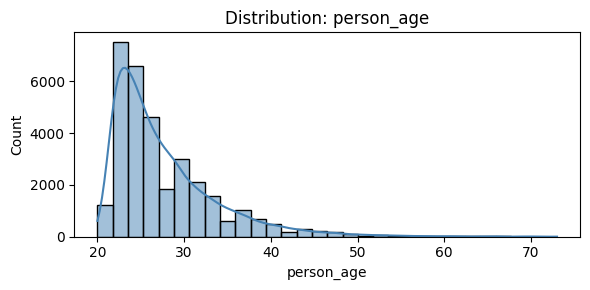

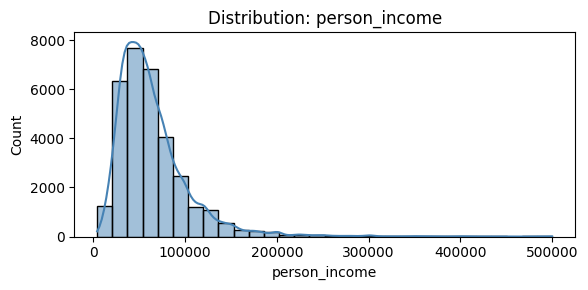

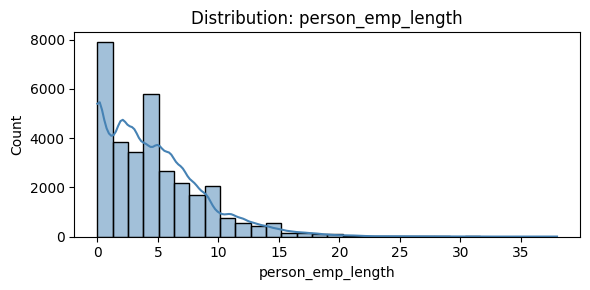

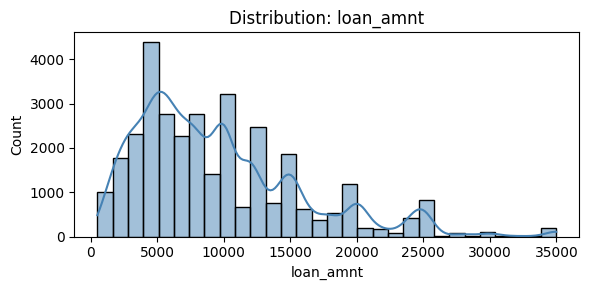

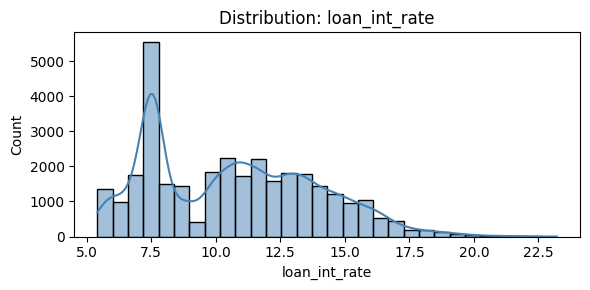

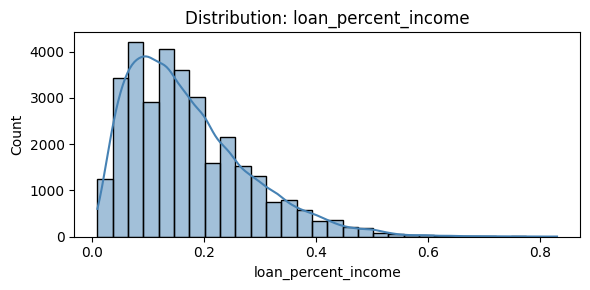

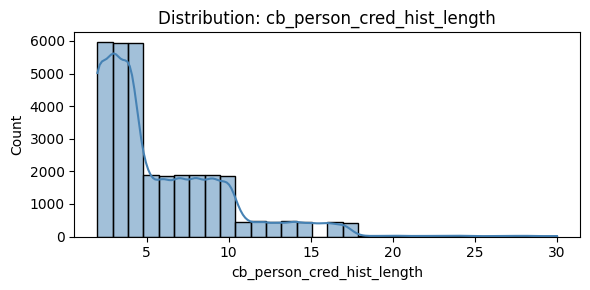

In [ ]:
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], bins=30, kde=True, color='steelblue')
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


### Correlations between numerical features


Correlation (Non-defaulted loans)
+---+----------------------------+------------+---------------+-------------------+-----------+---------------+---------------------+----------------------------+-------------+
| # |          Feature           | person_age | person_income | person_emp_length | loan_amnt | loan_int_rate | loan_percent_income | cb_person_cred_hist_length | loan_status |
+---+----------------------------+------------+---------------+-------------------+-----------+---------------+---------------------+----------------------------+-------------+
| 1 |         person_age         |    1.0     |     0.12      |       0.17        |   0.05    |     0.01      |        -0.04        |            0.88            |    -0.02    |
| 2 |       person_income        |    0.12    |      1.0      |       0.19        |    0.4    |      0.0      |        -0.34        |            0.1             |    -0.21    |
| 3 |     person_emp_length      |    0.17    |     0.19      |        1.0      

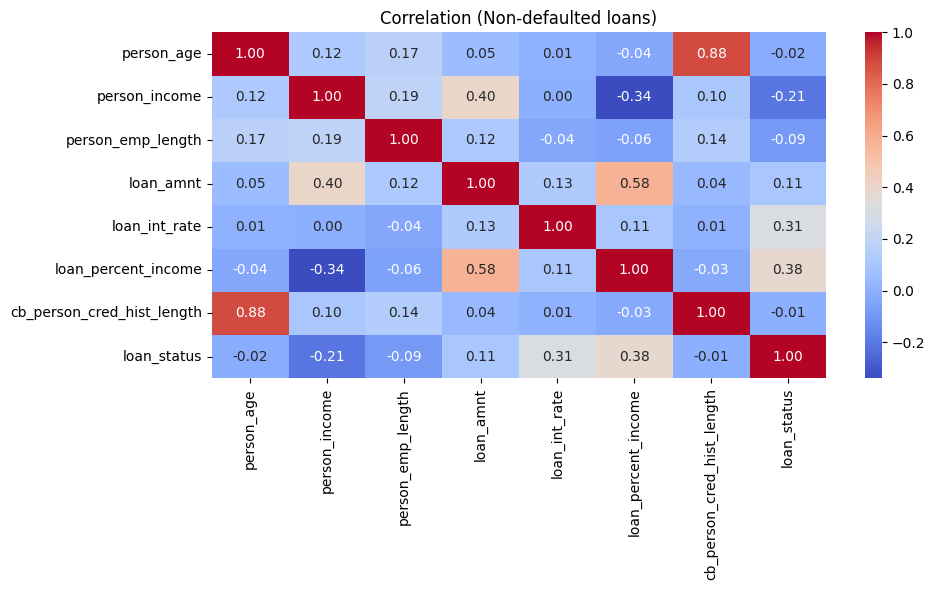


Correlation (Defaulted loans)
+---+----------------------------+------------+---------------+-------------------+-----------+---------------+---------------------+----------------------------+-------------+
| # |          Feature           | person_age | person_income | person_emp_length | loan_amnt | loan_int_rate | loan_percent_income | cb_person_cred_hist_length | loan_status |
+---+----------------------------+------------+---------------+-------------------+-----------+---------------+---------------------+----------------------------+-------------+
| 1 |         person_age         |    1.0     |     0.12      |       0.17        |   0.05    |     0.01      |        -0.04        |            0.88            |    -0.02    |
| 2 |       person_income        |    0.12    |      1.0      |       0.19        |    0.4    |      0.0      |        -0.34        |            0.1             |    -0.21    |
| 3 |     person_emp_length      |    0.17    |     0.19      |        1.0        | 

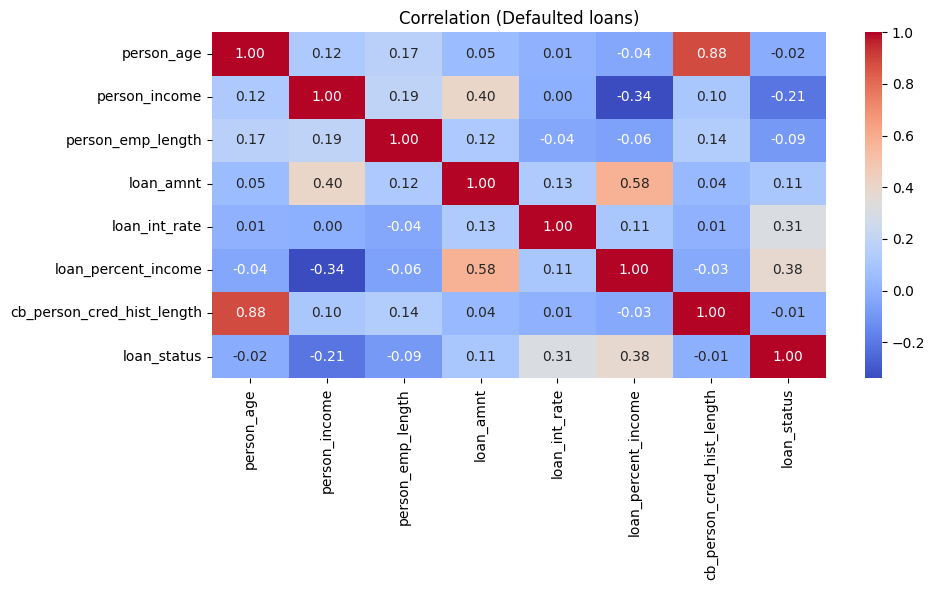

In [ ]:
def show_correlation(data, title, size):
    corr_matrix = corr.reset_index().rename(columns={'index': 'Feature'})
    corr_matrix.insert(0, '#', range(1, len(corr_matrix) + 1))

    print(f"\n{title}")
    print(tabulate(corr_matrix, headers='keys', tablefmt='pretty', showindex=False))

    plt.figure(figsize=size)
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(title)
    plt.tight_layout()
    plt.show()

corr = df[num_cols + ['loan_status']].corr().round(2)
size = (10,6)
#loan_status = 0
show_correlation(corr[corr['loan_status'] == 0], "Correlation (Non-defaulted loans)", size)

#loan_status = 1
show_correlation(corr[corr['loan_status'] == 1], "Correlation (Defaulted loans)", size)


## Analysis of categorical features


person_home_ownership:
+-----------------------+---------+--------+---------+------------------+
| person_home_ownership |    0    |   1    |  Total  | Default rate (%) |
+-----------------------+---------+--------+---------+------------------+
|       MORTGAGE        | 11726.0 | 1685.0 | 13411.0 |       12.6       |
|         OTHER         |  72.0   |  33.0  |  105.0  |       31.4       |
|          OWN          | 2387.0  | 193.0  | 2580.0  |       7.5        |
|         RENT          | 11231.0 | 5190.0 | 16421.0 |       31.6       |
+-----------------------+---------+--------+---------+------------------+


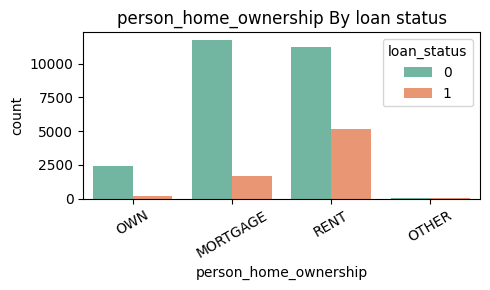


loan_intent:
+-------------------+--------+--------+--------+------------------+
|    loan_intent    |   0    |   1    | Total  | Default rate (%) |
+-------------------+--------+--------+--------+------------------+
| DEBTCONSOLIDATION | 3712.0 | 1490.0 | 5202.0 |       28.6       |
|     EDUCATION     | 5337.0 | 1111.0 | 6448.0 |       17.2       |
|  HOMEIMPROVEMENT  | 2658.0 | 941.0  | 3599.0 |       26.1       |
|      MEDICAL      | 4435.0 | 1618.0 | 6053.0 |       26.7       |
|     PERSONAL      | 4411.0 | 1094.0 | 5505.0 |       19.9       |
|      VENTURE      | 4863.0 | 847.0  | 5710.0 |       14.8       |
+-------------------+--------+--------+--------+------------------+


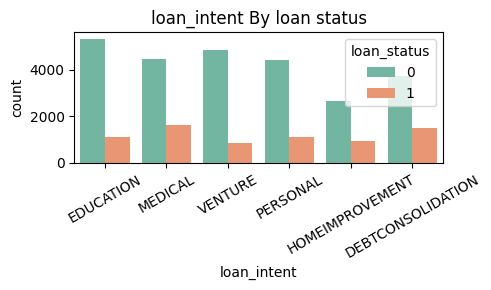


loan_grade:
+------------+--------+--------+---------+------------------+
| loan_grade |   0    |   1    |  Total  | Default rate (%) |
+------------+--------+--------+---------+------------------+
|     A      | 9684.0 | 1073.0 | 10757.0 |       10.0       |
|     B      | 8729.0 | 1699.0 | 10428.0 |       16.3       |
|     C      | 5106.0 | 1338.0 | 6444.0  |       20.8       |
|     D      | 1482.0 | 2138.0 | 3620.0  |       59.1       |
|     E      | 343.0  | 620.0  |  963.0  |       64.4       |
|     F      |  71.0  | 170.0  |  241.0  |       70.5       |
|     G      |  1.0   |  63.0  |  64.0   |       98.4       |
+------------+--------+--------+---------+------------------+


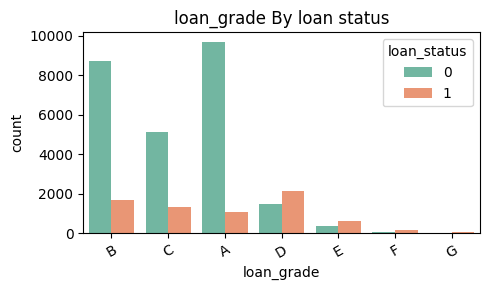


cb_person_default_on_file:
+---------------------------+---------+--------+---------+------------------+
| cb_person_default_on_file |    0    |   1    |  Total  | Default rate (%) |
+---------------------------+---------+--------+---------+------------------+
|             N             | 21851.0 | 4934.0 | 26785.0 |       18.4       |
|             Y             | 3565.0  | 2167.0 | 5732.0  |       37.8       |
+---------------------------+---------+--------+---------+------------------+


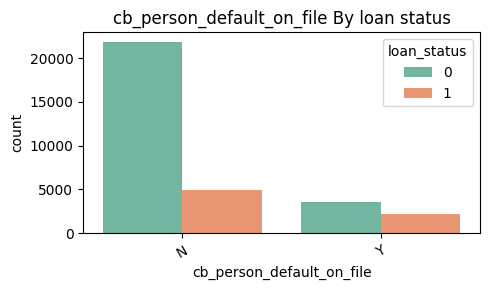

In [ ]:
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

for col in cat_cols:
    freq_table = df.groupby([col, 'loan_status']).size().unstack(fill_value=0)
    freq_table['Total'] = freq_table.sum(axis=1)
    freq_table['Default rate (%)'] = (freq_table[1] / freq_table['Total'] * 100).round(1)
    print(f"\n{col}:")
    print(tabulate(freq_table, headers='keys', tablefmt='pretty'))

    plt.figure(figsize=(5,3))
    sns.countplot(data=df, x=col, hue='loan_status', palette='Set2')
    plt.title(f"{col} By loan status")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# **2. Data Preprocessing**




##New feature engineering

In [ ]:
# Features based on EDA insights
df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']
df['credit_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']
df['emp_stability_ratio'] = df['person_emp_length'] / df['person_age']

# Interaction features
df['debt_capacity_index'] = df['loan_percent_income'] * df['loan_int_rate']
df['financial_experience_index'] = df['credit_age_ratio'] * df['person_emp_length']

# Flags based on risk patterns
df['is_home_owner_flg'] = df['person_home_ownership'].apply(lambda x: 1 if x in ['OWN', 'MORTGAGE'] else 0)
df['is_high_risk_grade_flg'] = df['loan_grade'].apply(lambda x: 1 if x in ['D', 'E', 'F', 'G'] else 0)
df['has_prev_default_flg'] = df['cb_person_default_on_file'].apply(lambda x: 1 if x == 'Y' else 0)


### Encoding categorical features

In [ ]:
# One-hot encode categorical feature
df_encoded = pd.get_dummies(df, columns=['loan_intent'], drop_first=True)

# Convert boolean (True/False) to numeric (1/0)
bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
df_encoded.columns = df_encoded.columns.str.lower()

info_df = pd.DataFrame({
    "Data type": df_encoded.dtypes,
    "Non-null count": df_encoded.count(),
    "Missing values": df_encoded.isnull().sum()
}).reset_index().rename(columns={'index': 'Feature'})
info_df.insert(0, '#', range(1, len(info_df) + 1))
print("Dataset structure and missing values")
print(tabulate(info_df, headers="keys", tablefmt="pretty", showindex=False))

Dataset structure and missing values
+----+-----------------------------+-----------+----------------+----------------+
| #  |           Feature           | Data type | Non-null count | Missing values |
+----+-----------------------------+-----------+----------------+----------------+
| 1  |         person_age          |   int64   |     32517      |       0        |
| 2  |        person_income        |   int64   |     32517      |       0        |
| 3  |    person_home_ownership    |  object   |     32517      |       0        |
| 4  |      person_emp_length      |  float64  |     32517      |       0        |
| 5  |         loan_grade          |  object   |     32517      |       0        |
| 6  |          loan_amnt          |   int64   |     32517      |       0        |
| 7  |        loan_int_rate        |  float64  |     32517      |       0        |
| 8  |         loan_status         |   int64   |     32517      |       0        |
| 9  |     loan_percent_income     |  float64  |  

### Normalization

In [ ]:
num_cols = [
    'person_age', 'person_income', 'person_emp_length',
    'loan_amnt', 'loan_int_rate', 'loan_percent_income',
    'cb_person_cred_hist_length', 'loan_to_income_ratio',
    'credit_age_ratio', 'emp_stability_ratio',
    'debt_capacity_index', 'financial_experience_index'
]

scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

In [ ]:
print(f"Dataset size: {df_encoded.shape[0]} rows × {df_encoded.shape[1]} columns\n")

print("First 5 rows:")
print(tabulate(df_encoded.head(), headers="keys", tablefmt="pretty", showindex=False))


Dataset size: 32517 rows × 24 columns

First 5 rows:
+---------------------+----------------------+-----------------------+----------------------+------------+---------------------+---------------------+-------------+---------------------+---------------------------+----------------------------+----------------------+----------------------+----------------------+---------------------+----------------------------+-------------------+------------------------+----------------------+-----------------------+-----------------------------+---------------------+----------------------+---------------------+
|     person_age      |    person_income     | person_home_ownership |  person_emp_length   | loan_grade |      loan_amnt      |    loan_int_rate    | loan_status | loan_percent_income | cb_person_default_on_file | cb_person_cred_hist_length | loan_to_income_ratio |   credit_age_ratio   | emp_stability_ratio  | debt_capacity_index | financial_experience_index | is_home_owner_flg | is_high_ri

### Save preprocessed data

In [ ]:
useful_features = [
    'loan_status',

    'person_income', 'loan_int_rate', 'cb_person_cred_hist_length',

    'loan_to_income_ratio', 'credit_age_ratio', 'emp_stability_ratio',
    'debt_capacity_index', 'financial_experience_index',
    'is_home_owner_flg', 'is_high_risk_grade_flg', 'has_prev_default_flg',

    'loan_intent_education', 'loan_intent_homeimprovement',
    'loan_intent_medical', 'loan_intent_personal', 'loan_intent_venture'
]

df_final = df_encoded[useful_features].copy()
output_path = "credit_risk_preprocessed.csv"
df_final.to_csv(output_path, index=False)

print(f"Preprocessed dataset saved as '{output_path}' successfully!")

Preprocessed dataset saved as 'credit_risk_preprocessed.csv' successfully!


###Updated correlation matrix


Correlation after feature engineering & scaling (Non-defaulted loans)
+----+----------------------------+------------+---------------+-------------------+-----------+---------------+---------------------+----------------------------+----------------------+------------------+---------------------+---------------------+----------------------------+-------------+
| #  |          Feature           | person_age | person_income | person_emp_length | loan_amnt | loan_int_rate | loan_percent_income | cb_person_cred_hist_length | loan_to_income_ratio | credit_age_ratio | emp_stability_ratio | debt_capacity_index | financial_experience_index | loan_status |
+----+----------------------------+------------+---------------+-------------------+-----------+---------------+---------------------+----------------------------+----------------------+------------------+---------------------+---------------------+----------------------------+-------------+
| 1  |         person_age         |    1.0     |  

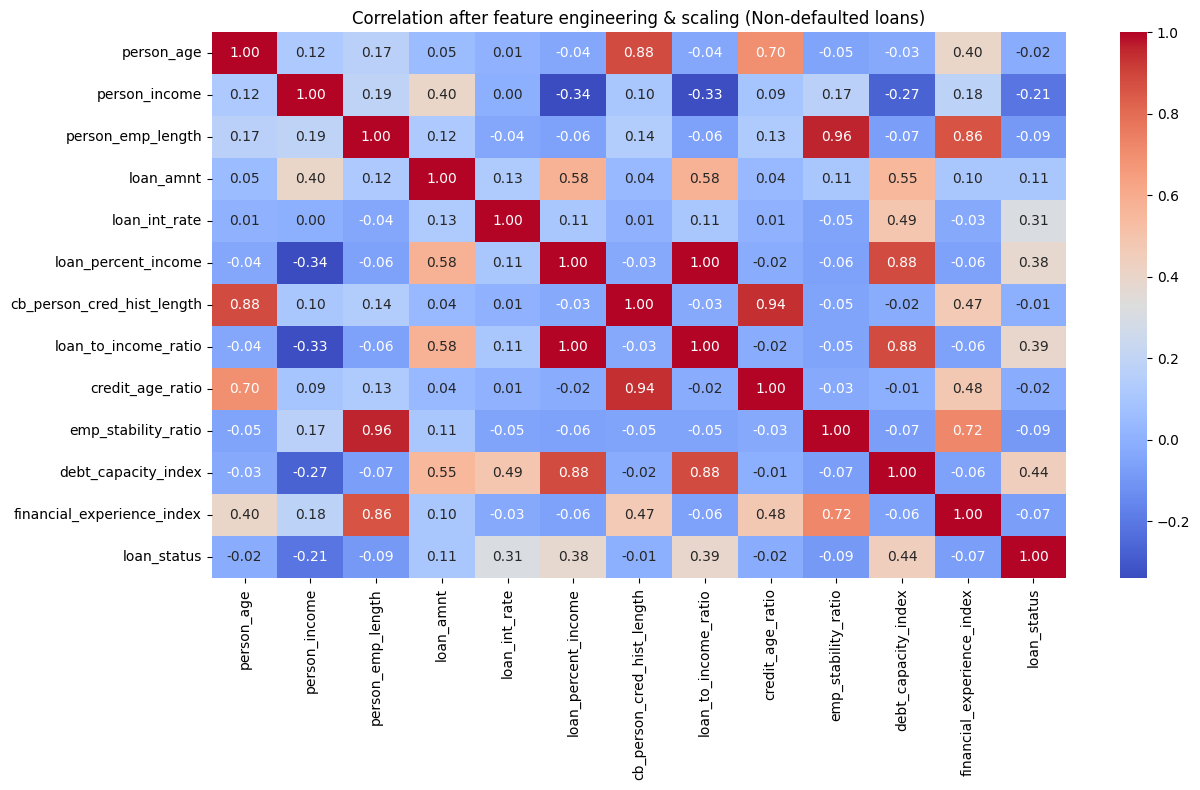


Correlation after feature engineering & scaling (Defaulted loans)
+----+----------------------------+------------+---------------+-------------------+-----------+---------------+---------------------+----------------------------+----------------------+------------------+---------------------+---------------------+----------------------------+-------------+
| #  |          Feature           | person_age | person_income | person_emp_length | loan_amnt | loan_int_rate | loan_percent_income | cb_person_cred_hist_length | loan_to_income_ratio | credit_age_ratio | emp_stability_ratio | debt_capacity_index | financial_experience_index | loan_status |
+----+----------------------------+------------+---------------+-------------------+-----------+---------------+---------------------+----------------------------+----------------------+------------------+---------------------+---------------------+----------------------------+-------------+
| 1  |         person_age         |    1.0     |     0

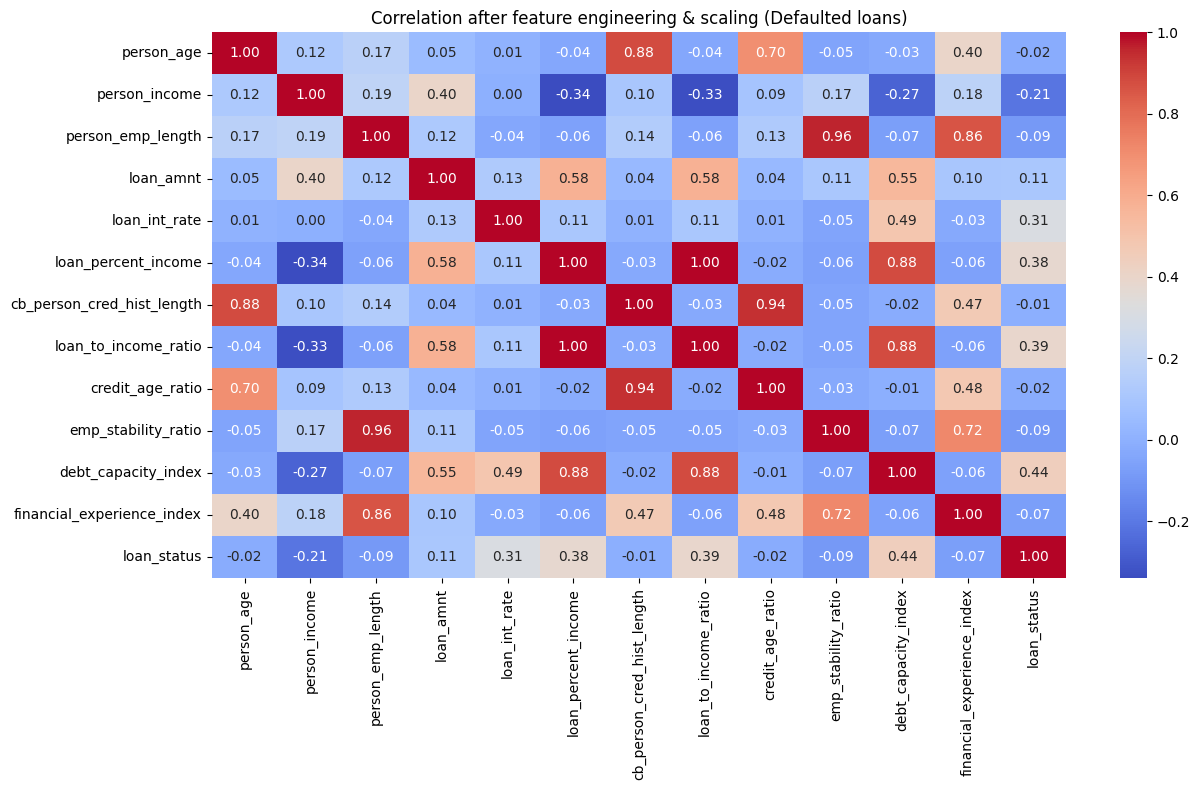

In [ ]:
corr = df_encoded[num_cols + ['loan_status']].corr().round(2)
size = (13,8)

#loan_status = 0
show_correlation(corr[corr['loan_status'] == 0], "Correlation after feature engineering & scaling (Non-defaulted loans)", size)

#loan_status = 1
show_correlation(corr[corr['loan_status'] == 1], "Correlation after feature engineering & scaling (Defaulted loans)", size)